<font size=6><b> KOSPI 예측모델 (by 뉴스 긍부정 비율)

In [3]:
from IPython.display import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import time
import datetime

from scipy import stats
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

import plotly.graph_objects as go
from plotly.subplots import make_subplots

import warnings
warnings.filterwarnings(action='ignore')

sns.set()
#-------------------- 차트 관련 속성 (한글처리, 그리드) -----------
#plt.rc('font', family='NanumGothicOTF') # For MacOS
plt.rcParams['font.family']= 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False


#-------------------- 주피터 , 출력결과 넓이 늘리기 ---------------
from IPython.core.display import display, HTML
display(HTML("<style>.container{width:100% !important;}</style>"))
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('max_colwidth', None)

pd.options.plotting.backend = "plotly"

# 중립뉴스 제거 여부
DEL_NEUT = True

# 가상화폐 관련 뉴스 제거 여부
DEL_COINNEWS = True

# Negative 뉴스 가중치
NEG_WEIGHT = 2

In [4]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from keras.models import Sequential
from keras.models import Model

from keras.layers import Dense, LSTM, TimeDistributed,Input, Flatten
import os

from sklearn.metrics import mean_squared_error 
from keras.layers import Bidirectional, Dropout

# KOSPI data load

In [5]:
kospi = pd.read_csv('./datasets/kospi/kospidf.csv', parse_dates=['일자'])
kospi = kospi[kospi['일자'] >= '2021-01-01']
kospi = kospi.set_index('일자')
kospi.head()

,종가,대비,등락률,시가,고가,저가,거래량,거래대금,상장시가총액
일자,,,,,,,,,
2021-01-04,2944.45,70.98,2.47,2874.50,2946.54,2869.11,1026510.0,25011394.0,2.028846e+09
2021-01-05,2990.57,46.12,1.57,2943.67,2990.57,2921.84,1519912.0,26548380.0,2.059744e+09
2021-01-06,2968.21,-22.36,-0.75,2993.34,3027.16,2961.37,1793419.0,29909396.0,2.044103e+09
2021-01-07,3031.68,63.47,2.14,2980.75,3055.28,2980.75,1524655.0,27182807.0,2.086579e+09
2021-01-08,3152.18,120.50,3.97,3040.11,3161.11,3040.11,1297903.0,40909490.0,2.170538e+09


In [6]:
def convert_up_down(p):
    label = 0
    if p>=0:
        label = 1
    return label

kospi['등락여부'] = kospi['등락률'].apply(convert_up_down)  # 분류모델 학습시 활용
kospi.head()

,종가,대비,등락률,시가,고가,저가,거래량,거래대금,상장시가총액,등락여부
일자,,,,,,,,,,
2021-01-04,2944.45,70.98,2.47,2874.50,2946.54,2869.11,1026510.0,25011394.0,2.028846e+09,1
2021-01-05,2990.57,46.12,1.57,2943.67,2990.57,2921.84,1519912.0,26548380.0,2.059744e+09,1
2021-01-06,2968.21,-22.36,-0.75,2993.34,3027.16,2961.37,1793419.0,29909396.0,2.044103e+09,0
2021-01-07,3031.68,63.47,2.14,2980.75,3055.28,2980.75,1524655.0,27182807.0,2.086579e+09,1
2021-01-08,3152.18,120.50,3.97,3040.11,3161.11,3040.11,1297903.0,40909490.0,2.170538e+09,1


In [7]:
kospi = kospi[['등락률','등락여부']]
kospi.head()

,등락률,등락여부
일자,,
2021-01-04,2.47,1
2021-01-05,1.57,1
2021-01-06,-0.75,0
2021-01-07,2.14,1
2021-01-08,3.97,1


In [8]:
kospi.tail()

,등락률,등락여부
일자,,
2023-05-24,0.00,1
2023-05-25,-0.50,0
2023-05-26,0.16,1
2023-05-30,1.04,1
2023-05-31,-0.32,0


In [9]:
len(kospi)

596

# Predict data load

In [10]:
newsdf = pd.read_csv('./datasets/newsdf_pred_0614_samsung_seoul.csv', parse_dates=['key_rdate'])
# newsdf = pd.read_csv('./datasets/newsdf_pred_0614_samsung.csv', parse_dates=['key_rdate'])
newsdf = newsdf.sort_values('key_rdate')
newsdf = newsdf[newsdf['key_rdate'] >= '2021-01-01']

newsdf = newsdf.reset_index()
newsdf = newsdf.drop('index', axis=1)

print(f'dataset lenght : {len(newsdf)}')
newsdf.head()

dataset lenght : 133511


,key_rdate,key_title,label
0,2021-01-01 07:00:00,[신축년 새해 재운] '金' 기운 올해도 여전...7월 기점으로 코로나 위기 갈무리될 듯,0
1,2021-01-01 07:00:00,[신축년 띠별 운세],0
2,2021-01-01 08:00:00,"IT·2차전지·경기민감株 '맑음'…저금리·실적 타고 3,000 간다",0
3,2021-01-01 08:05:00,"""새해 증시도 高高""…고객예탁금 65.6조 사상 최고",1
4,2021-01-01 08:30:00,"동학개미 멘토의 새해 투자 코칭…""흥분 말고 냉철할 때""",0


## 데이터 전처리

* 중립 뉴스 제거 (중립 뉴스 살리려면 해당 코드 주석처리)

In [11]:
if DEL_NEUT == True:
    newsdf = newsdf[newsdf['label'] != 0]
    newsdf = newsdf.reset_index()
    newsdf = newsdf.drop('index', axis=1)

* 가상화폐 관련 뉴스 제거

In [12]:
if DEL_COINNEWS == True:
    dellist = []
    for i in range(len(newsdf)):
        if '비트코인' in newsdf.loc[i, 'key_title'] or '가상화폐' in newsdf.loc[i, 'key_title'] or \
        '이더리움' in newsdf.loc[i, 'key_title'] or '알트코인' in newsdf.loc[i, 'key_title']:
            dellist.append(i)

    newsdf = newsdf.drop(dellist)
    newsdf = newsdf.reset_index()
    newsdf = newsdf.drop('index', axis=1)
newsdf.head()

,key_rdate,key_title,label
0,2021-01-01 08:05:00,"""새해 증시도 高高""…고객예탁금 65.6조 사상 최고",1
1,2021-01-01 09:10:00,2020 뉴욕증시 '역대 최고치' 피날레…다우·S&P도 신기록 썼다,1
2,2021-01-01 09:53:00,"동학개미 덕에 코스피 시가총액, 사상 최초 GDP 넘어선 듯",2
3,2021-01-01 10:01:00,4월부터 불법 공매도 감시·처벌 강화,1
4,2021-01-02 09:12:00,[2021 산업]⑤ 결국 AI서 결판난다...4대 그룹 현주소는,2


* 장중, 장외 시간 Labeling

In [13]:
def convert_open_close(d):
    label = 0
    if d.hour >= 9 and d.hour < 15:
        label = 1
    return label

# open(장중)이면 1, close(장외)이면 0
newsdf['open_close'] = newsdf['key_rdate'].apply(convert_open_close)
newsdf.head()

,key_rdate,key_title,label,open_close
0,2021-01-01 08:05:00,"""새해 증시도 高高""…고객예탁금 65.6조 사상 최고",1,0
1,2021-01-01 09:10:00,2020 뉴욕증시 '역대 최고치' 피날레…다우·S&P도 신기록 썼다,1,1
2,2021-01-01 09:53:00,"동학개미 덕에 코스피 시가총액, 사상 최초 GDP 넘어선 듯",2,1
3,2021-01-01 10:01:00,4월부터 불법 공매도 감시·처벌 강화,1,1
4,2021-01-02 09:12:00,[2021 산업]⑤ 결국 AI서 결판난다...4대 그룹 현주소는,2,1


* 장마감후 저녁 Lableing
    * 날짜처리를 위해 필요

In [14]:
def convert_night(d):
    label = 0
    if d.hour > 15 and d.hour <= 23:
        label = 1
    return label

# 장마감 후 저녁 시간대면 1 아니면 0 
newsdf['night'] = newsdf['key_rdate'].apply(convert_night)

# 장이 마감했다면, 날짜를 다음날로 넘김.
# 당일의 장중 뉴스는 다음날의 KOSPI를 예측하기 위해 활용되기 때문에 장중 뉴스도 다음날로 넘김.

for i in range(len(newsdf)):
    if newsdf.loc[i, 'night'] == 1:
        newsdf.loc[i, 'key_rdate'] = newsdf.loc[i, 'key_rdate'] + datetime.timedelta(days=1)
    elif newsdf.loc[i, 'open_close'] == 1:
        newsdf.loc[i, 'key_rdate'] = newsdf.loc[i, 'key_rdate'] + datetime.timedelta(days=1)

newsdf['key_rdate'] = newsdf['key_rdate'].dt.date
newsdf = newsdf.set_index('key_rdate')
newsdf.head()

,key_title,label,open_close,night
key_rdate,,,,
2021-01-01,"""새해 증시도 高高""…고객예탁금 65.6조 사상 최고",1,0,0
2021-01-02,2020 뉴욕증시 '역대 최고치' 피날레…다우·S&P도 신기록 썼다,1,1,0
2021-01-02,"동학개미 덕에 코스피 시가총액, 사상 최초 GDP 넘어선 듯",2,1,0
2021-01-02,4월부터 불법 공매도 감시·처벌 강화,1,1,0
2021-01-03,[2021 산업]⑤ 결국 AI서 결판난다...4대 그룹 현주소는,2,1,0


In [15]:
newsdf['pos'] = np.where(newsdf['label']==1, 1, 0)
newsdf['neg'] = np.where(newsdf['label']==2, 1, 0)
newsdf.head()

,key_title,label,open_close,night,pos,neg
key_rdate,,,,,,
2021-01-01,"""새해 증시도 高高""…고객예탁금 65.6조 사상 최고",1,0,0,1,0
2021-01-02,2020 뉴욕증시 '역대 최고치' 피날레…다우·S&P도 신기록 썼다,1,1,0,1,0
2021-01-02,"동학개미 덕에 코스피 시가총액, 사상 최초 GDP 넘어선 듯",2,1,0,0,1
2021-01-02,4월부터 불법 공매도 감시·처벌 강화,1,1,0,1,0
2021-01-03,[2021 산업]⑤ 결국 AI서 결판난다...4대 그룹 현주소는,2,1,0,0,1


## 날짜별 그룹화

In [16]:
newsdfcnt = newsdf.groupby('key_rdate')['label'].count()
grnewsdf = newsdf.groupby('key_rdate')[['pos', 'neg']].sum()

newsdf2 = pd.concat([grnewsdf, newsdfcnt], axis=1)

In [17]:
newsdf2['pos_rate'] = newsdf2['pos']/newsdf2['label']
newsdf2['neg_rate'] = newsdf2['neg']/newsdf2['label']
newsdf2['pos_neg_rate'] = (newsdf2['pos']-newsdf2['neg'])/newsdf2['label']
newsdf2['pos_neg_wrate'] = (newsdf2['pos']-(newsdf2['neg']*NEG_WEIGHT))/newsdf2['label']

cidx = newsdf2[newsdf2['pos_neg_wrate']<-1].index
newsdf2.loc[cidx, 'pos_neg_wrate'] = -1
newsdf2.head(3)

,pos,neg,label,pos_rate,neg_rate,pos_neg_rate,pos_neg_wrate
key_rdate,,,,,,,
2021-01-01,1,0,1,1.000000,0.000000,1.000000,1.0
2021-01-02,2,1,3,0.666667,0.333333,0.333333,0.0
2021-01-03,2,1,3,0.666667,0.333333,0.333333,0.0


* 장중 뉴스

In [18]:
opendf = newsdf[newsdf['open_close'] == 1]
opendf.head(3)

,key_title,label,open_close,night,pos,neg
key_rdate,,,,,,
2021-01-02,2020 뉴욕증시 '역대 최고치' 피날레…다우·S&P도 신기록 썼다,1,1,0,1,0
2021-01-02,"동학개미 덕에 코스피 시가총액, 사상 최초 GDP 넘어선 듯",2,1,0,0,1
2021-01-02,4월부터 불법 공매도 감시·처벌 강화,1,1,0,1,0


In [19]:
preddfcnt = opendf.groupby('key_rdate')['label'].count()
preddf_gr = opendf.groupby('key_rdate')[['pos', 'neg']].sum()

cdf_open = pd.concat([preddf_gr, preddfcnt], axis=1)
cdf_open.head(3)

,pos,neg,label
key_rdate,,,
2021-01-02,2,1,3
2021-01-03,0,1,1
2021-01-04,8,1,9


In [20]:
cdf_open['pos_rate'] = cdf_open['pos']/cdf_open['label']
cdf_open['neg_rate'] = cdf_open['neg']/cdf_open['label']
cdf_open['pos_neg_rate'] = (cdf_open['pos']-cdf_open['neg'])/cdf_open['label']
cdf_open['pos_neg_wrate'] = (cdf_open['pos']-(cdf_open['neg']*NEG_WEIGHT))/cdf_open['label']

cidx = cdf_open[cdf_open['pos_neg_wrate']<-1].index
cdf_open.loc[cidx, 'pos_neg_wrate'] = -1
cdf_open.head(3)

,pos,neg,label,pos_rate,neg_rate,pos_neg_rate,pos_neg_wrate
key_rdate,,,,,,,
2021-01-02,2,1,3,0.666667,0.333333,0.333333,0.000000
2021-01-03,0,1,1,0.000000,1.000000,-1.000000,-1.000000
2021-01-04,8,1,9,0.888889,0.111111,0.777778,0.666667


In [21]:
newsopen = cdf_open[['pos_rate', 'neg_rate', 'pos_neg_wrate']]
newsopen.columns = ['장중_긍정비율','장중_부정비율','장중_긍부정비율']
newsopen.head(3)

,장중_긍정비율,장중_부정비율,장중_긍부정비율
key_rdate,,,
2021-01-02,0.666667,0.333333,0.000000
2021-01-03,0.000000,1.000000,-1.000000
2021-01-04,0.888889,0.111111,0.666667


* 장마감후, 장전 뉴스

In [22]:
closedf = newsdf[newsdf['open_close'] == 0]

preddfcnt = closedf.groupby('key_rdate')['label'].count()
preddf_gr = closedf.groupby('key_rdate')[['pos', 'neg']].sum()

cdf_close = pd.concat([preddf_gr, preddfcnt], axis=1)
cdf_close.head(3)

,pos,neg,label
key_rdate,,,
2021-01-01,1,0,1
2021-01-03,2,0,2
2021-01-04,22,2,24


In [23]:
cdf_close['pos_rate'] = cdf_close['pos']/cdf_close['label']
cdf_close['neg_rate'] = cdf_close['neg']/cdf_close['label']
cdf_close['pos_neg_rate'] = (cdf_close['pos']-cdf_close['neg'])/cdf_close['label']
cdf_close['pos_neg_wrate'] = (cdf_close['pos']-(cdf_close['neg']*2))/cdf_close['label']

cidx = cdf_close[cdf_close['pos_neg_wrate']<-1].index
cdf_close.loc[cidx, 'pos_neg_wrate'] = -1

cdf_close.head(3)

,pos,neg,label,pos_rate,neg_rate,pos_neg_rate,pos_neg_wrate
key_rdate,,,,,,,
2021-01-01,1,0,1,1.000000,0.000000,1.000000,1.00
2021-01-03,2,0,2,1.000000,0.000000,1.000000,1.00
2021-01-04,22,2,24,0.916667,0.083333,0.833333,0.75


In [24]:
newsclose = cdf_close[['pos_rate', 'neg_rate', 'pos_neg_wrate']]
newsclose.columns = ['장외_긍정비율','장외_부정비율','장외_긍부정비율']
newsclose.head(3)

,장외_긍정비율,장외_부정비율,장외_긍부정비율
key_rdate,,,
2021-01-01,1.000000,0.000000,1.00
2021-01-03,1.000000,0.000000,1.00
2021-01-04,0.916667,0.083333,0.75


# DataFrame Concat

In [25]:
df = pd.merge(newsopen, newsclose, left_index=True, right_index=True, how='outer')
df = df.dropna()

df = pd.merge(df, kospi, left_index=True, right_index=True, how='outer')
df = df.dropna()
df  # KOSPI 개수만큼 나옴 dataframe 생성됨.

,장중_긍정비율,장중_부정비율,장중_긍부정비율,장외_긍정비율,장외_부정비율,장외_긍부정비율,등락률,등락여부
2021-01-04,0.888889,0.111111,0.666667,0.916667,0.083333,0.750000,2.47,1.0
2021-01-05,0.951613,0.048387,0.854839,0.900000,0.100000,0.700000,1.57,1.0
2021-01-06,0.837209,0.162791,0.511628,0.864865,0.135135,0.594595,-0.75,0.0
2021-01-07,0.850746,0.149254,0.552239,0.897436,0.102564,0.692308,2.14,1.0
2021-01-08,1.000000,0.000000,1.000000,0.929825,0.070175,0.789474,3.97,1.0
...,...,...,...,...,...,...,...,...
2023-05-24,0.954545,0.045455,0.863636,0.869565,0.130435,0.608696,0.00,1.0
2023-05-25,0.766667,0.233333,0.300000,0.611111,0.388889,-0.166667,-0.50,0.0
2023-05-26,0.821429,0.178571,0.464286,0.653846,0.346154,-0.038462,0.16,1.0
2023-05-30,1.000000,0.000000,1.000000,0.925926,0.074074,0.777778,1.04,1.0


In [26]:
train = df[df.index.year < 2023]
test = df[df.index.year == 2023]

In [27]:
train.head()

,장중_긍정비율,장중_부정비율,장중_긍부정비율,장외_긍정비율,장외_부정비율,장외_긍부정비율,등락률,등락여부
2021-01-04,0.888889,0.111111,0.666667,0.916667,0.083333,0.750000,2.47,1.0
2021-01-05,0.951613,0.048387,0.854839,0.900000,0.100000,0.700000,1.57,1.0
2021-01-06,0.837209,0.162791,0.511628,0.864865,0.135135,0.594595,-0.75,0.0
2021-01-07,0.850746,0.149254,0.552239,0.897436,0.102564,0.692308,2.14,1.0
2021-01-08,1.000000,0.000000,1.000000,0.929825,0.070175,0.789474,3.97,1.0


In [28]:
test.head()

,장중_긍정비율,장중_부정비율,장중_긍부정비율,장외_긍정비율,장외_부정비율,장외_긍부정비율,등락률,등락여부
2023-01-02,0.666667,0.333333,0.000000,0.600000,0.400000,-0.200000,-0.48,0.0
2023-01-03,0.843750,0.156250,0.531250,0.606061,0.393939,-0.181818,-0.31,0.0
2023-01-04,0.794872,0.205128,0.384615,0.657895,0.342105,-0.026316,1.68,1.0
2023-01-05,0.854167,0.145833,0.562500,0.847826,0.152174,0.543478,0.38,1.0
2023-01-06,0.900000,0.100000,0.700000,0.606061,0.393939,-0.181818,1.12,1.0


In [29]:
len(train)

494

In [30]:
# train.to_csv('./datasets/traindf.csv')
# test.to_csv('./datasets/testdf.csv')

# Make Sequence data

In [31]:
# 학습 데이터 생성 (입력데이터 X, 결과 데이터 Y)
X = []
Y = []
for i in range(5, len(train)):
    temp = []
    for j in range(5, 0, -1):
        temp.append(train.iloc[i-j, :3])
        temp.append(train.iloc[i-j, 3:6])
    X.append(temp)
    Y.append([train.iloc[i,6]])
    
X = np.array(X)
Y = np.array(Y)

In [32]:
# np.save('./datasets/lstm_input/x_train1.npy', X)
# np.save('./datasets/lstm_input/y_train1.npy', Y)

# Train data Load (Concat)

In [33]:
x1 = np.load('./datasets/lstm_input/x_train1.npy')
x2 = np.load('./datasets/lstm_input/x_train2.npy')
x3= np.load('./datasets/lstm_input/x_train3.npy')

y1 = np.load('./datasets/lstm_input/y_train1.npy')
y2 = np.load('./datasets/lstm_input/y_train2.npy')
y3 = np.load('./datasets/lstm_input/y_train3.npy')

In [34]:
X = np.concatenate((x1, x2, x3), axis=0)
Y = np.concatenate((y1, y2, y3), axis=0)

In [35]:
# Test 데이터 (입력데이터 X, 결과 데이터 Y)
X_test = []
Y_test = []
for i in range(5, len(test)):
    temp = []
    for j in range(5, 0, -1):
        temp.append(test.iloc[i-j, :3])
        temp.append(test.iloc[i-j, 3:6])
    X_test.append(temp)
    Y_test.append([test.iloc[i,6]])
    
X_test = np.array(X_test)
Y_test = np.array(Y_test)

# Model Train & Test

In [36]:
# # LSTM 모델 구성
# # LSTM 레이어 50개층, Dense 레이어 1개층으로 구성된 모델

# leaky_relu = tf.nn.leaky_relu

# # 최고 성능의 모델 파일을 저장할 이름과 경로 설정
# BEST_MODEL_NAME = './model/lstm_reg_model2_v2.h5'

# model_checkpoint = ModelCheckpoint(
#     filepath = BEST_MODEL_NAME,
#     monitor = "val_loss",
#     mode = "min",
#     save_best_only = True, # 성능 향상 시에만 모델 저장
#     verbose = 1
# )
# callbacks = [model_checkpoint]


# model = Sequential()
# model.add(LSTM(50, input_shape=(10, 3),return_sequences=True))
# model.add(LSTM(20))
# model.add(Dense(10, activation='tanh'))
# model.add(Dense(1, activation='linear'))
# model.compile(loss='mse', optimizer='adam')  # 'adam'


# # 모델 학습, epochs=100 는 100회 학습을 의미한다.
# model.fit(X, Y, epochs=150, batch_size=32, validation_data = (X_test, Y_test), callbacks = callbacks)

In [37]:
# # LSTM 모델 구성
# # LSTM 레이어 50개층, Dense 레이어 1개층으로 구성된 모델

# leaky_relu = tf.nn.leaky_relu

# # 최고 성능의 모델 파일을 저장할 이름과 경로 설정
# BEST_MODEL_NAME = './model/lstm_reg_model3_v1.h5'

# model_checkpoint = ModelCheckpoint(
#     filepath = BEST_MODEL_NAME,
#     monitor = "val_loss",
#     mode = "min",
#     save_best_only = True, # 성능 향상 시에만 모델 저장
#     verbose = 1
# )
# callbacks = [model_checkpoint]


# inp = Input(shape=(10, 3))
# x = LSTM(50, return_sequences=True)(inp)
# x = LSTM(20, return_sequences=True)(x)
# x = Flatten()(x)
# x = Dense(10,  activation='tanh')(x)
# x = Dense(1,  activation='linear')(x)
# # model = Model(inp, x)

# model.compile(loss='mse', optimizer='adam')   #optimizer

# model.fit(X, Y, epochs=200, batch_size=32, validation_data = (X_test, Y_test), callbacks = callbacks)

In [40]:
model = tf.keras.models.load_model('./model/regression_model_v2/lstm_reg_model2_v2.h5')
pred= model.predict(X_test)
mse = mean_squared_error(Y_test, pred)
mse, mse**(1/2)

4/4 [==============================] - 1s 3ms/step


(0.4441045334817207, 0.6664116846827648)

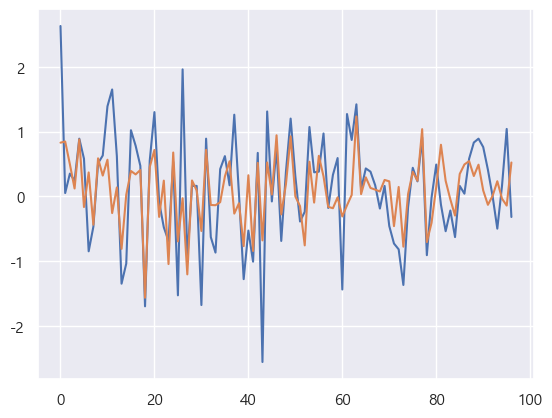

In [41]:
plt.plot(Y_test)
plt.plot(pred)
plt.show()

In [ ]:
# # 최고 성능의 모델 파일을 저장할 이름과 경로 설정
# BEST_MODEL_NAME = './model/bi-lstm_reg_model2.h5'


# model_checkpoint = ModelCheckpoint(
#     filepath = BEST_MODEL_NAME,
#     monitor = "val_loss",
#     mode = "min",
#     save_best_only = True, # 성능 향상 시에만 모델 저장
#     verbose = 1
# )


# # LSTM 모델 구성
# # LSTM 레이어 50개층, Dense 레이어 1개층으로 구성된 모델

# callbacks = [model_checkpoint]


# leaky_relu = tf.nn.leaky_relu

# model = Sequential()
# model.add(Bidirectional(LSTM(50, return_sequences=True), input_shape = (10,3)))
# model.add(Dropout(0.3))
# model.add(Bidirectional(LSTM(20)))
# model.add(Dropout(0.3))
# model.add(Dense(10, activation='tanh'))
# model.add(Dropout(0.3))
# model.add(Dense(1, activation='linear'))
# model.compile(loss='mse', optimizer='adam')  # 'adam'

# # 모델 학습, epochs=100 는 100회 학습을 의미한다.
# model.fit(X, Y, epochs=200, batch_size=32, validation_data = (X_test, Y_test), callbacks = callbacks)

In [ ]:
# # 최고 성능의 모델 파일을 저장할 이름과 경로 설정
# BEST_MODEL_NAME = './model/bi-lstm_reg_model3.h5'


# model_checkpoint = ModelCheckpoint(
#     filepath = BEST_MODEL_NAME,
#     monitor = "val_loss",
#     mode = "min",
#     save_best_only = True, # 성능 향상 시에만 모델 저장
#     verbose = 1
# )


# # LSTM 모델 구성
# # LSTM 레이어 50개층, Dense 레이어 1개층으로 구성된 모델

# callbacks = [model_checkpoint]

# inp = Input(shape=(10, 3))
# x = Bidirectional(LSTM(50, return_sequences=True), input_shape = (10,3))(inp)
# x = Bidirectional(LSTM(20))(x)
# x = Flatten()(x)
# x = Dense(10,  activation='tanh')(x)
# x = Dense(1,  activation='linear')(x)
# model = Model(inp, x)
# model.compile(loss='mse', optimizer='adam')  # 'adam'

# model.fit(X, Y, epochs=150, batch_size=32, validation_data = (X_test, Y_test), callbacks = callbacks)

In [42]:
model = tf.keras.models.load_model('./model/regression_model_v2/bi-lstm_reg_model2_v2.h5')
pred= model.predict(X_test)
mse = mean_squared_error(Y_test, pred)
mse, mse**(1/2)

4/4 [==============================] - 1s 4ms/step


(0.32046599980000434, 0.5660971646281266)

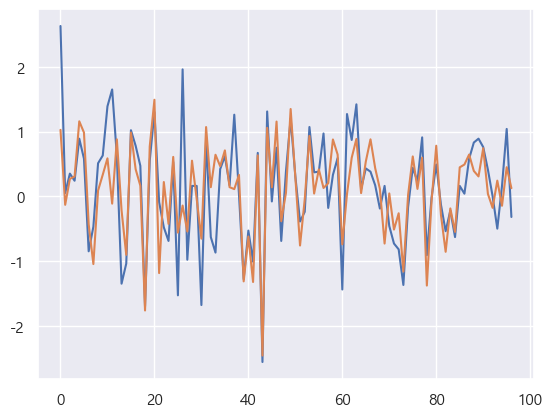

In [43]:
plt.plot(Y_test)
plt.plot(pred)
plt.show()